# Week 2 - Augmented Perception

For this notebook we will be using the following packages

In [2]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import sklearn.metrics.pairwise
import sklearn.manifold

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
%matplotlib inline

import json #For reading data from github's API
import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20
Newsgroups corpus*, a dataset commonly used to illustrate text applications of
text clustering and classification. This comes packaged with sklearn and
comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly
across 20 newsgroups. It was originally collected by Ken Lang, probably for his
1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into
20 distinct newsgroups, each corresponding to a different topic. Some of the
newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware /
comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale /
soc.religion.christian).

In [3]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train') #, data_home = '~/shared/sklearnData'
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with
`filenames`

In [4]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous
information and converting it into a DataFrame.

In [5]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'])#, data_home = '~/shared/sklearnData'
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"""auto\nfrom"
4,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g.,
*soc.religion.christian message a* might contain 3 mentions of "church", 2 of
"jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [6]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is
mostly zeros, so we store it as a sparse matrix, a data structure that contains
and indexes only the nonzero entries.

In [7]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal
matrix (not recommended for large sparse matrices :-)

In [8]:
newsgroupsVects[:10,:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [9]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.
org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.ht
ml)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('trees', 0.046688020755456),
 ('acheived', 0.1589865268627092),
 ('subharmonic', 0.22685454684169398),
 ('fishtailing', 0.14113625048015269),
 ('gregory', 0.1817286448065436),
 ('knox', 0.16194122924300089),
 ('timed', 0.074956903065618502),
 ('supplier', 0.074842993100868407),
 ('5pm', 0.095991006908172),
 ('adelaide', 0.18819404816424326),
 ('attendees', 0.054640923210934937),
 ('gory', 0.1109950967372947),
 ('21045', 0.12601141569529475),
 ('north', 0.19706119834212132),
 ('ha', 0.24220644191410201),
 ('cord', 0.16299450361806797),
 ('mobs', 0.15540750198460515),
 ('idaho', 0.057498781219299681),
 ('pistons', 0.04330392033255178),
 ('greyscale', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered
list with unique words and stopwords. Note, however, that words like *apple*,
*rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a
much lower weight. Note that we could filter out stop words, stem and lem our
data before vectorizering, or we can instead use tf-idf to filter our data (or
**both**). For exact explanation of all options look [here](http://scikit-learn.
org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.htm
l). To prune this matrix of features, we now limit our word vector to 1000 words
with at least 3 occurrences, which do not occur in more than half of the
documents. There is an extensive science and art to feature engineering for
machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

The matrix is much smaller now, only 1000 words, but the same number of
documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['require', 'went', 'functions', 'volume', 'position', 'transmission', 'paid', 'processor', 'directory', 'consider'] ...


This is a reasonable matrix of features with which to begin identifying
clusters.

# Flat Clustering with K-means

Lets start with k-means, an approach that begins with random clusters of
predefined number, then iterates cluster reassignment and evaluates the new
clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the
*true number* of clusters is 4. Of course, in most cases you would not know the
number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that
sklearn provides. We will look at a few.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("for our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_curve', 'precision_recall_fsc

We can also look at the contents of the clusters:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 cars
 engine
 like
 just
 good
 think
 don
 dealer
 new


Cluster 1:
 window
 server
 use
 motif
 using
 program
 widget
 application
 thanks
 code


Cluster 2:
 mac
 know
 just
 drive
 apple
 like
 does
 don
 thanks
 problem


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('comp.sys.mac.hardware', 'red'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

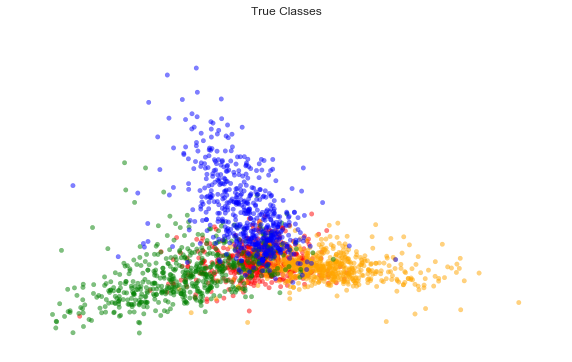

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

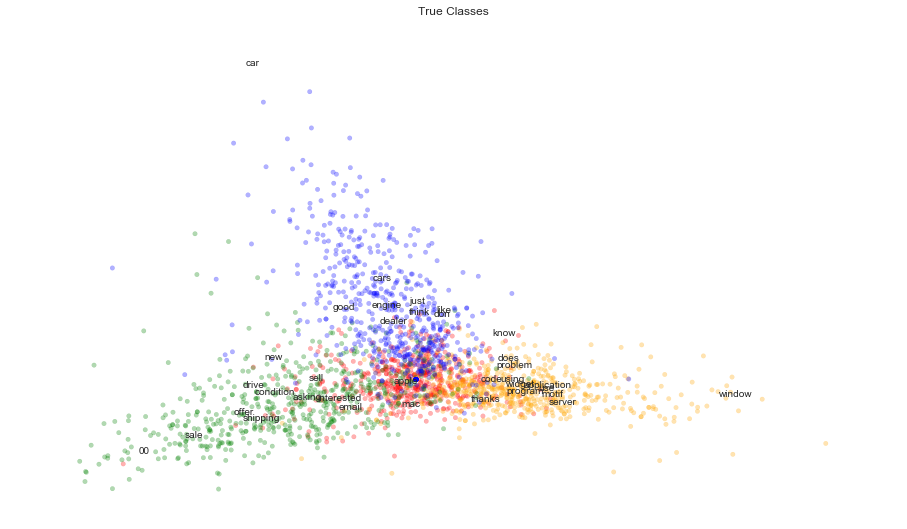

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

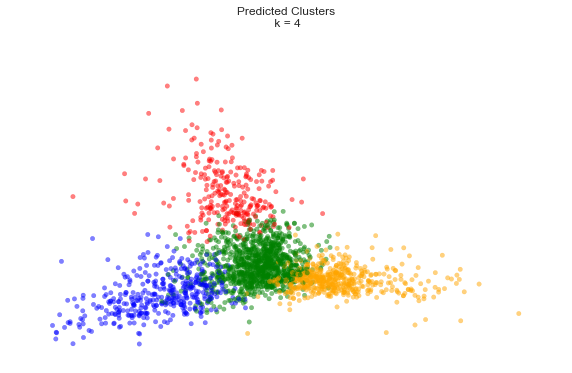

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

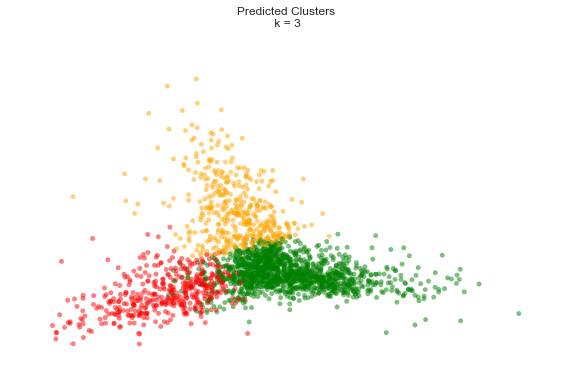

In [28]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km3.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

# Selecting Cluster Number

Now we demonstrate the Silhouette method, one approach by which optimal number
of clusters can be ascertained. Many other methods exist (e.g., Bayesian
Information Criteria or BIC, the visual "elbow criteria", etc.)

For n_clusters = 2 The average silhouette_score is : 0.0112425822659


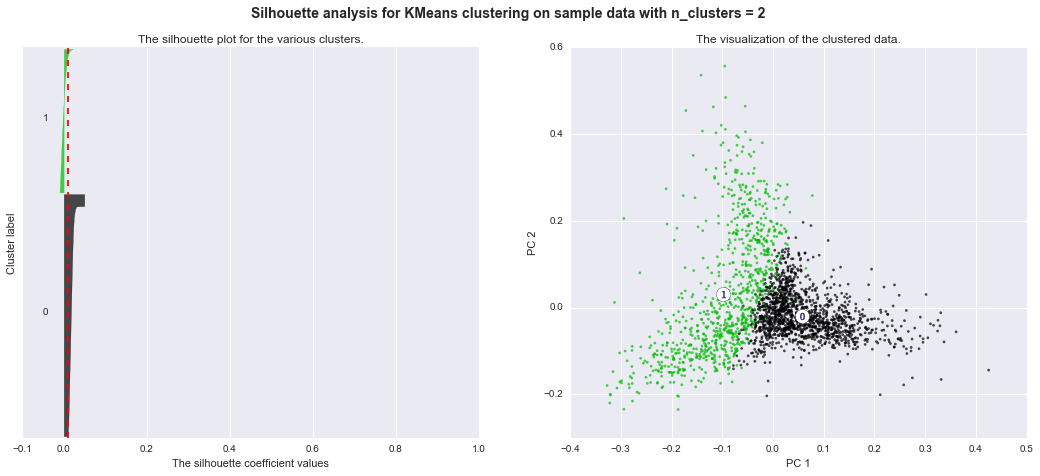

For n_clusters = 3 The average silhouette_score is : 0.0137278857552


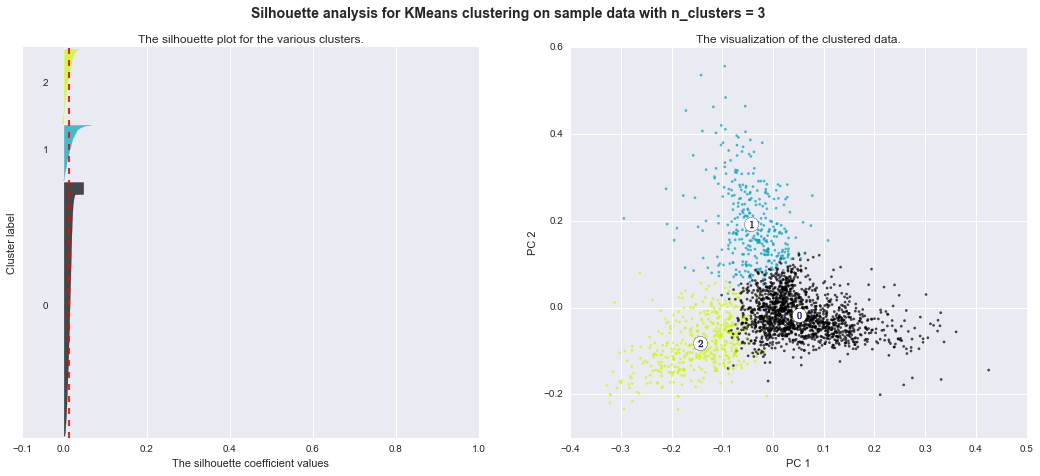

For n_clusters = 4 The average silhouette_score is : 0.0123967613052


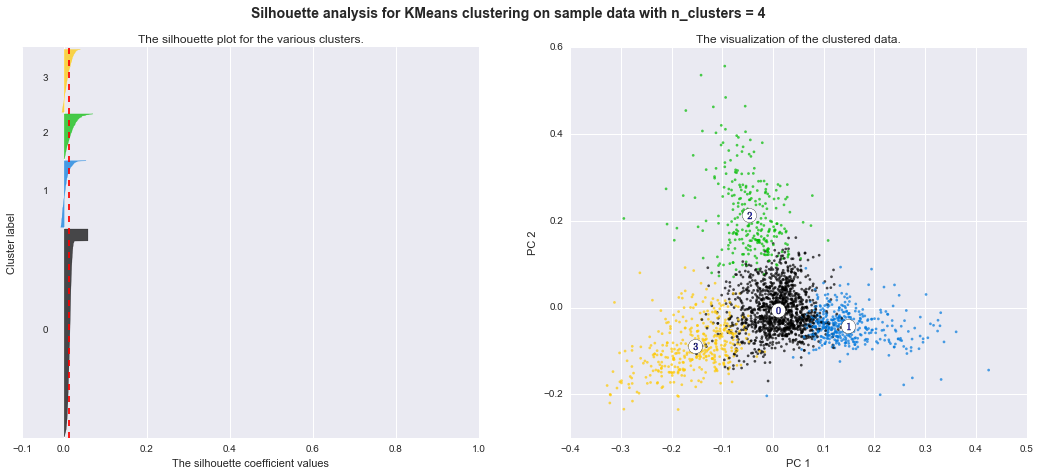

For n_clusters = 5 The average silhouette_score is : 0.0100142110129


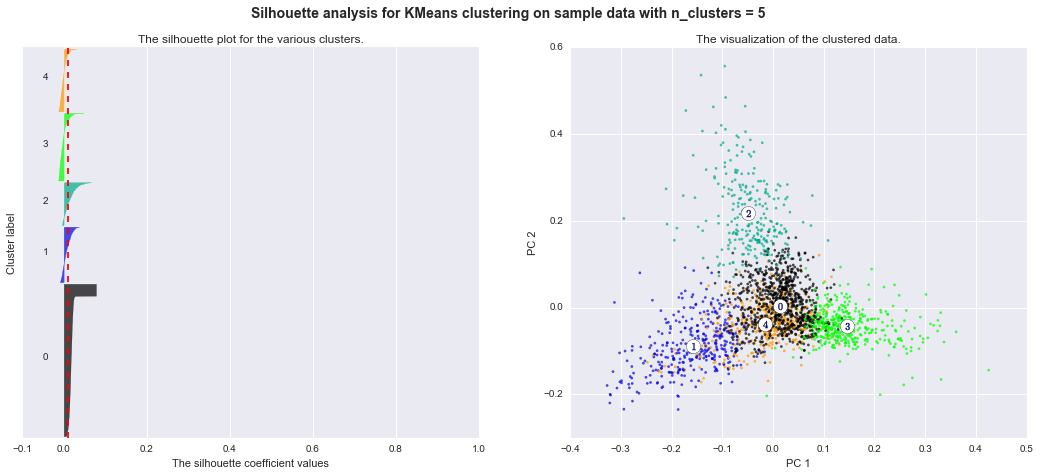

For n_clusters = 6 The average silhouette_score is : 0.0111918953479


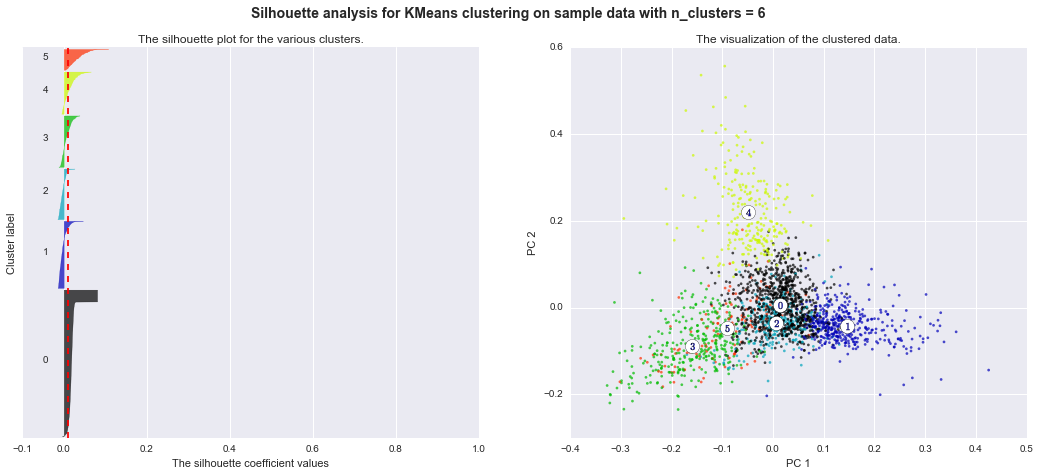

In [29]:
range_n_clusters = [2, 3, 4, 5, 6]
X = newsgroupsTFVects.toarray()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Interestingly, the silhouette scores above suggests that 3 is a better number of
clusters than 4, which would be accurate if we (reasonsably) grouped the two
computer-themed groups.


# Getting arbitrary text data

Lets start by defining the same function as last lesson and loading a few press
releases from 10 different senators into a DataFrame. The code to do this is
below, but commented out as we've already downloaded the data to the data
directory.

In [30]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)

    #Check for rate limiting
    if r.status_code != 200:
        raise RuntimeError("Github didn't like your request, you have probably been rate limited.")
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize

The normalized text is good, but we know that the texts will have a large amount
of overlap so we can use tf-idf to remove some of the most frequent words.
Before doing that, there is one empty cell, let's remove that.

In [31]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [32]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly
convert code from one input to another. Below we are redoing the cluster
detection with our senate data. If you setup your DataFrame the same way it
should be able to run on this code, without much work.

First we will define what we will be working with

In [33]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [34]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [35]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize, this is more up to you, but we will do one

In [36]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

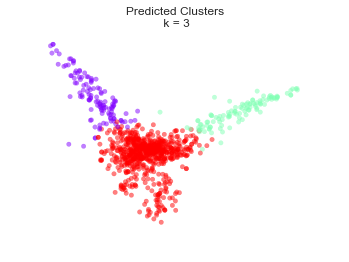

In [37]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there are probably two clusters. You can check with a Silhouette
analysis.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters
at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one
could perform the converse operation, a document occurrence matrix measuring how
similar  words are to each other based on their number of collocated documents).

In [38]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the
first 100 texts.

In [39]:
linkage_matrix = scipy.cluster.hierarchy.ward(newsgroupsCoocMat[:100, :100].toarray())
linkage_matrix[:10]

array([[   3.        ,   26.        ,    0.        ,    2.        ],
       [  52.        ,  100.        ,    0.        ,    3.        ],
       [  68.        ,  101.        ,    0.        ,    4.        ],
       [  75.        ,  102.        ,    0.        ,    5.        ],
       [  76.        ,  103.        ,    0.        ,    6.        ],
       [  82.        ,  104.        ,    0.        ,    7.        ],
       [  99.        ,  105.        ,    0.        ,    8.        ],
       [  71.        ,   97.        ,    0.28035552,    2.        ],
       [  22.        ,   55.        ,    0.28134893,    2.        ],
       [  21.        ,  107.        ,    0.31355623,    3.        ]])

Now we can visualize the tree

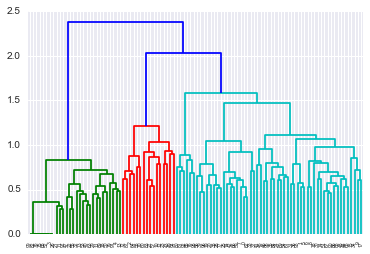

In [40]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the
tree after a number of branchings.

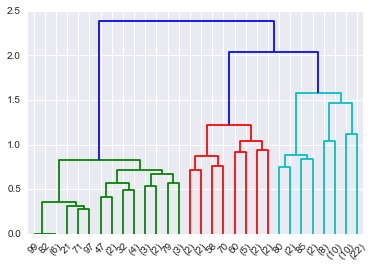

In [41]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level')

By default, the tree is colored to show the clusters based on their ['distance']
(https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hiera
rchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but
there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this
with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.c
luster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the
tree into 4 clusters

In [42]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 2, 1, 2, 1, 4, 4, 3, 4, 1, 4, 4, 1, 1,
       2, 4, 4, 1, 2, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4,
       4, 1, 4, 2, 1, 4, 1, 1, 4, 1, 4, 2, 2, 4, 2, 4, 4, 1, 2, 4, 4, 4, 1,
       4, 2, 1, 2, 1, 4, 1, 1, 4, 4, 1, 3, 3, 1, 2, 4, 3, 4, 2, 4, 1, 4, 1,
       3, 4, 2, 4, 4, 1, 3, 1], dtype=int32)

This gives us an array giving each element of `linkage_matrix`'s cluster. The
leader function below is actually quite misleading. In this case, the ids it
returns are actually not document ids but non-singleton clusters. You can ignore
this cell.

In [43]:
clusterLeaders = scipy.cluster.hierarchy.leaders(linkage_matrix, hierarchicalClusters)
clusterLeaders

(array([183, 195, 194, 178], dtype=int32), array([3, 4, 2, 1], dtype=int32))

# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by
creating the linkage matrix:

In [44]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


And visualize the tree:

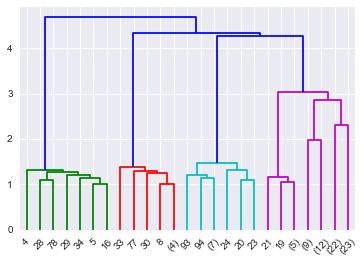

In [45]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Sometimes, it's not very interesting :-).


# Clustering Geographic Regions

One of the most amazing results of machine learing is that the input type of data doesn't matter. As long as a couple minor assumptions are true the the techiques will just work. We can use the exact same kmeans cluster we were using above for text with US census data. `data/natregimes.csv` contains demographic and homicide rates for 3085 American counties, the code book is in `data/natregimes.html` and the data are from the [Center for Spatial Data Science](https://spatial.uchicago.edu/sample-data). Lets see what clusters it produces.

First we need to load the data:

In [46]:
natregimesDF = pandas.read_csv('data/natregimes.csv')
natregimesDF[:5]

,REGIONS,NOSOUTH,POLY_ID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,West
0,1.0,1.0,1,Lake of the Woods,Minnesota,27,77,27077,27,77,...,0.024534,0.285235,0.372336,0.342104,0.336455,11.279621,5.4,5.663881,9.515860,0
1,2.0,1.0,2,Ferry,Washington,53,19,53019,53,19,...,0.317712,0.256158,0.360665,0.361928,0.360640,10.053476,2.6,10.079576,11.397059,1
2,2.0,1.0,3,Stevens,Washington,53,65,53065,53,65,...,0.210030,0.283999,0.394083,0.357566,0.369942,9.258437,5.6,6.812127,10.352015,1
3,2.0,1.0,4,Okanogan,Washington,53,47,53047,53,47,...,0.155922,0.258540,0.371218,0.381240,0.394519,9.039900,8.1,10.084926,12.840340,1
4,2.0,1.0,5,Pend Oreille,Washington,53,51,53051,53,51,...,0.134605,0.243263,0.365614,0.358706,0.387848,8.243930,4.1,7.557643,10.313002,1


Lets create a vector for each countie:

In [47]:
nonData = ['REGIONS',
 'NOSOUTH',
 'POLY_ID',
 'NAME',
 'STATE_NAME',
 'STATE_FIPS',
 'CNTY_FIPS',
 'FIPS',
 'STFIPS',
 'COFIPS',
 'FIPSNO',
 'SOUTH',
 'West']
natregimesDataDF = natregimesDF.drop(nonData, axis=1).astype('float')
natregimesDF['vect'] = [v.reshape(1, -1) for v in natregimesDataDF.as_matrix()]

We have lots of ways of defining categories from counties but lets start with something simple: 'North-West', 'South-West', 'North-East' or 'South-West' since the provided data has that encoded already:

In [48]:
locsDict = {
    (0,0) : 'North-West',
    (1,0) : 'South-West', 
    (0,1) :'North-East',
    (1,1) : 'South-West'
}
natregimesDF['category'] = [locsDict[(r['SOUTH'], r['West'])] for i, r in natregimesDF.iterrows()]

We can now do some cluster detection:

In [49]:
natregimesKMeans = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')
natregimesKMeans.fit(np.stack(natregimesDF['vect'], axis=1)[0])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Look at the how well it it works:

In [50]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(natregimesDF['category'], natregimesKMeans.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(natregimesDF['category'], natregimesKMeans.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(natregimesDF['category'], natregimesKMeans.labels_)))

Homogeneity: 0.004
Completeness: 0.017
V-measure: 0.006


We can use PCA again to see how well the data match the model:

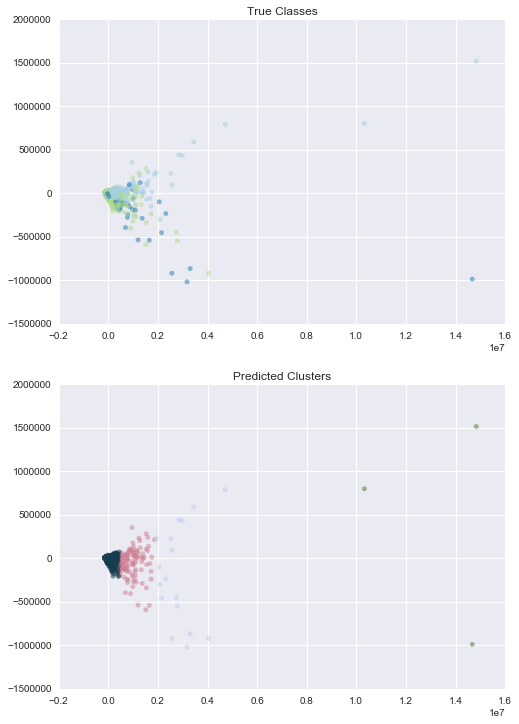

In [51]:
pca = sklearn.decomposition.PCA(n_components = 2).fit(np.stack(natregimesDF['vect'], axis=1)[0])
reduced_data = pca.transform(np.stack(natregimesDF['vect'], axis=1)[0])

categories = list(set(natregimesDF['category']))
palletTrue = seaborn.color_palette("Paired", len(categories))
palletPred = seaborn.color_palette("cubehelix", len(set((natregimesKMeans.labels_))))

coloursDict = {c : palletTrue[i] for i, c in enumerate(categories)}
coloursTrue = [coloursDict[c] for c in natregimesDF['category']]
colorsPred = [palletPred[l] for l in natregimesKMeans.labels_]


fig = plt.figure(figsize = (8,12))
axT = fig.add_subplot(211)
axP = fig.add_subplot(212)

axT.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha = 0.5, color = coloursTrue)
axT.set_title('True Classes')

axP.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colorsPred, alpha = 0.5)
axP.set_title('Predicted Clusters')
plt.show()
plt.close()

Not very good, but what if we look at population density instead of location?

In [52]:
numClusters = 7

populationSeries = natregimesDF['HC90'].astype('float')

quartiles = []
for i in range(numClusters - 1):
    quartiles.append(np.percentile(populationSeries, (1 + i) / numClusters * 100))
    
def categorizer(popNum):
    for i, cutVal in enumerate(quartiles):
        if popNum <= cutVal:
            return 'Q{}'.format(i + 1)
    #floating point numbers are tricky
    return 'Q{}'.format(len(quartiles) + 1)

natregimesDF['category'] = [categorizer(p) for p in populationSeries]

Redoing the clustering:

In [53]:
natregimesKMeans2 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
natregimesKMeans2.fit(np.stack(natregimesDF['vect'], axis=1)[0])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And looking at the metrics

In [54]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(natregimesDF['category'], natregimesKMeans2.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(natregimesDF['category'], natregimesKMeans2.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(natregimesDF['category'], natregimesKMeans2.labels_)))

Homogeneity: 0.104
Completeness: 0.412
V-measure: 0.167


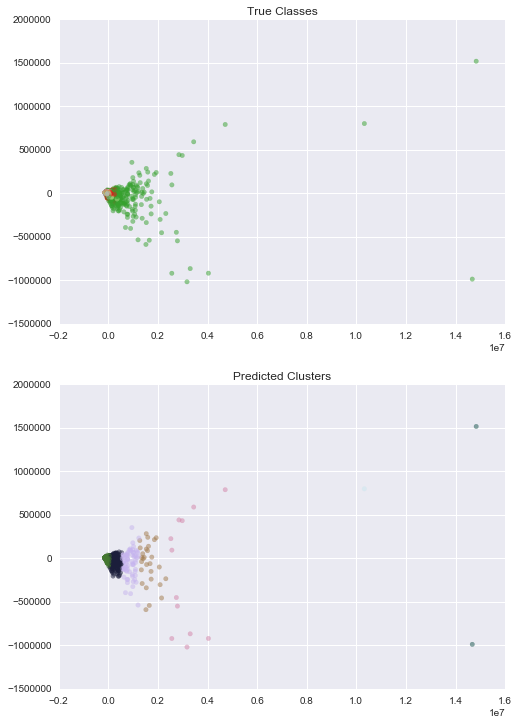

In [55]:
pca = sklearn.decomposition.PCA(n_components = 2).fit(np.stack(natregimesDF['vect'], axis=1)[0])
reduced_data = pca.transform(np.stack(natregimesDF['vect'], axis=1)[0])

categories = list(set(natregimesDF['category']))
palletTrue = seaborn.color_palette("Paired", len(categories))
palletPred = seaborn.color_palette("cubehelix", len(set((natregimesKMeans2.labels_))))

coloursDict = {c : palletTrue[i] for i, c in enumerate(categories)}
coloursTrue = [coloursDict[c] for c in natregimesDF['category']]
colorsPred = [palletPred[l] for l in natregimesKMeans2.labels_]


fig = plt.figure(figsize = (8,12))
axT = fig.add_subplot(211)
axP = fig.add_subplot(212)

axT.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha = 0.5, color = coloursTrue)
axT.set_title('True Classes')

axP.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colorsPred, alpha = 0.5)
axP.set_title('Predicted Clusters')
plt.show()
plt.close()

Not that good, but trying to predict 60 variables with just one rarely is.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases
corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts
with gensim we need to create a `corpua` object, this takes a few steps. First
we create a `Dictionary` that maps tokens to ids.

In [56]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [57]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [58]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and
its count. We will only use the first half of our dataset for now and will save
the remainder for testing.

In [59]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step
when the corpus is large.

In [60]:
gensim.corpora.MmCorpus.serialize('data/senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('data/senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and
induction.

In [61]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here
is one of the texts from the training set:

In [62]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(4, 0.96901559513928459)]


We can now see which topics our model predicts press releases load on and make
this into a `dataFrame` for later analysis.

In [63]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [64]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(6, 0.957047324194)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.957047,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(3, 0.99227084341)]",0.000000,0.000000,0.000000,0.992271,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(0, 0.221570264288), (2, 0.775812862709)]",0.221570,0.000000,0.775813,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(3, 0.997310245622)]",0.000000,0.000000,0.000000,0.997310,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(0, 0.989330462761)]",0.989330,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(2, 0.938143117014)]",0.000000,0.000000,0.938143,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(2, 0.958680807868)]",0.000000,0.000000,0.958681,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.329492463814), (1, 0.280737694842), (2,...",0.329492,0.280738,0.073576,0.000000,0.089074,0.0,0.030835,0.194547,0.000000,0.000000
801,15Dec2005Kennedy5.txt,"[(0, 0.632472844294), (4, 0.341885347095), (8,...",0.632473,0.000000,0.000000,0.000000,0.341885,0.0,0.000000,0.000000,0.023949,0.000000
901,16May2007Kennedy5.txt,"[(1, 0.284705715402), (8, 0.332522666187), (9,...",0.000000,0.284706,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.332523,0.349754


Now let's visualize this for several (e.g., 10) documents in the corpus. First
we'll subset the data:

In [65]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.000000,0.000000,0.000000,0.969016,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.957047,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.270112,0.000000,0.722097,0.000000
3,0.0,0.000000,0.000000,0.141588,0.000000,0.0,0.000000,0.850975,0.000000,0.000000
4,0.0,0.000000,0.000000,0.439362,0.000000,0.0,0.000000,0.000000,0.000000,0.557796
5,0.0,0.327893,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.663798
6,0.0,0.000000,0.981589,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.000000,0.952460,0.0,0.000000,0.000000,0.000000,0.013379
8,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.514989,0.000000,0.480464,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.966232,0.000000


First we can visualize as a stacked bar chart:

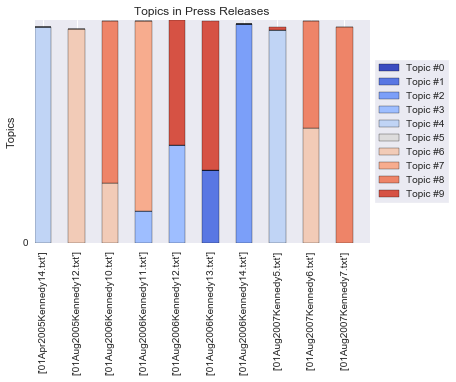

In [66]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

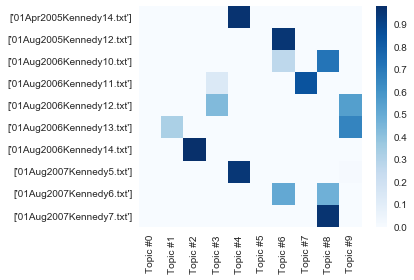

In [67]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic
(or syntactic) domain they represent. To look at the terms with the highest LDA
weight in topic `1` we can do the following:

In [68]:
senlda.show_topic(1)

[('mental', 0.010343544039042358),
 ('minimum', 0.010243737362018054),
 ('wage', 0.0095773598305475948),
 ('wagon', 0.0079093508665965314),
 ('effect', 0.0069331556074451999),
 ('teacher', 0.0064667578331901359),
 ('import', 0.0064577842227624936),
 ('treatment', 0.006380963951305791),
 ('worker', 0.0062621039479031429),
 ('depart', 0.0062210233616495185)]

And if we want to make a dataFrame:

In [69]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,mental,wagon,worker,fund,worker,depart,fund,loan,worker
1,head,minimum,fund,fund,troop,minimum,fund,fda,worker,pension
2,worker,wage,armor,depart,worker,wage,wagon,govern,lender,wage
3,victim,wagon,medicaid,amend,author,fund,author,loan,wage,employ
4,wagon,effect,worker,iraqi,unit,import,unit,import,rate,minimum
5,teacher,teacher,govern,wagon,import,hear,import,inform,minimum,fund
6,import,import,import,govern,commit,wagon,inform,author,govern,rule
7,doe,treatment,unit,employ,wagon,amend,assist,troop,employ,import
8,trust,worker,troop,doe,fail,border,govern,wagon,borrow,save
9,govern,depart,claim,victim,aid,hour,train,concern,wagon,earn


We can see that several of the topics have the same top words, but there are
definitely differences. We can try and make the topics more distinct by changing
the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity
of document-topic loadings, and $\eta$ controls the sparsity of topic-word
loadings.

We can make a visualization of the distribution of words over any single topic.

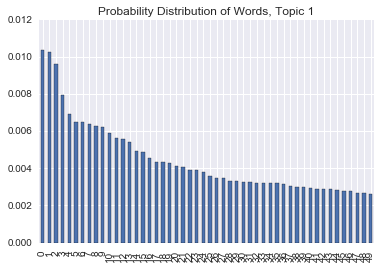

In [70]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [71]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

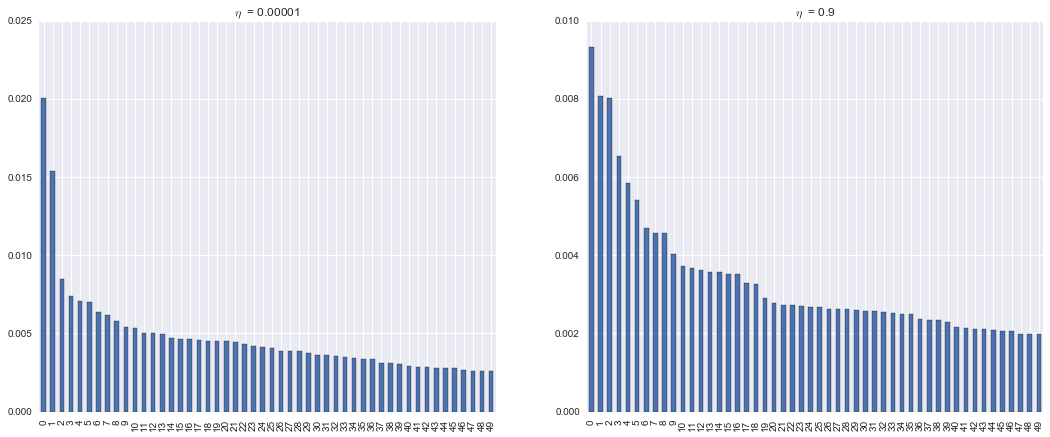

In [72]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

# Word Embeddings

To look at Word Embeddings we will keep using the senate data, but we need a large set to have something useful so we will load a few more senators, using the csvs in `data/grimmerPressReleases`.

We will load them into a DataFrame, but first we need to
define a function to convert directories of text files into DataFrames:

In [73]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in
`data/grimmerPressReleases`

In [74]:
dataDir = 'data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...


We also want to remove stop words and stem. Tokenizing requires two steps.
Word2Vec needs to retain the sentence structure so as to capture a "continuous
bag of words (CBOW)" and all of the skip-grams within a word window. The
algorithm tries to preserve the distances induced by one of these two local
structures. This is very different from clustering and LDA topic modeling which
extract unordered words alone. As such, tokenizing is slightly more involved.

In [75]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)

    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))

    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

In [76]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = stop_words_nltk, stemmer = None) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, se..."
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, plan..."
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, u,..."
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, senator, edward,..."
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, impo..."
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.co
m/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [77]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector
directly, use the square braces (`__getitem__`) method:

In [78]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 0.22245489,  0.25482041,  2.66738153, -0.22303265,  1.90918458,
       -0.41964078,  2.32258201, -0.01128588, -1.88894689, -2.53543544], dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [79]:
senReleasesW2V.syn0

array([[-0.19865444,  0.56997663,  0.78913134, ..., -1.67948163,
         1.33457363,  0.37888971],
       [-1.37306714,  1.43482244, -0.738392  , ..., -3.46315002,
         1.43540895, -1.40364993],
       [-1.75239861,  2.6856184 , -0.30811265, ..., -1.24152613,
         0.72200286,  0.23188452],
       ..., 
       [-0.04894245,  0.02969537,  0.02914293, ..., -0.05933196,
        -0.09951311, -0.03118525],
       [ 0.00641402,  0.00439485,  0.02165038, ..., -0.02350132,
        -0.07708248, -0.07446937],
       [ 0.01720272, -0.12338138, -0.07479077, ...,  0.06036118,
        -0.05936375, -0.02452219]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [80]:
senReleasesW2V.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to
find similar vectors (cosine similarity):

In [81]:
senReleasesW2V.most_similar('president')

[('administration', 0.7747381925582886),
 ('presidents', 0.7679776549339294),
 ('administrations', 0.6640158891677856),
 ('george', 0.6210470795631409),
 ('cheney', 0.6057288646697998),
 ('quoting', 0.5474882125854492),
 ('responds', 0.5217904448509216),
 ('ronald', 0.5107097029685974),
 ('gore', 0.4964497983455658),
 ('sims', 0.49410030245780945)]

In [82]:
senReleasesW2V.most_similar('war')

[('wars', 0.6655937433242798),
 ('disobedience', 0.6512415409088135),
 ('afghanistan', 0.6273856163024902),
 ('quagmire', 0.6202296614646912),
 ('invasion', 0.6096072196960449),
 ('unresisted', 0.606767475605011),
 ('chaos', 0.6009390950202942),
 ('battle', 0.5929007530212402),
 ('militarily', 0.5784416198730469),
 ('descending', 0.574923574924469)]

Find which word least matches the others within a word set (cosine similarity):

In [83]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek
the words whose vectors best fit the missing entry from the equation: **X + Y -
Z = _**.

In [84]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.7023857831954956),
 ('vetoed', 0.7005785703659058),
 ('veto', 0.6927342414855957),
 ('vetoes', 0.6787357926368713),
 ('blocked', 0.6672746539115906),
 ('bushs', 0.6614875197410583),
 ('signature', 0.653018593788147),
 ('signed', 0.6466110944747925),
 ('sign', 0.6088106632232666),
 ('proposing', 0.6045134663581848)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in
this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**.
Whoah!

We can also save the vectors for later use:

In [85]:
senReleasesW2V.save("data/senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by
selecting a subset we want to plot. Let's look at the top words from the set:

In [86]:
numWords = 50
targetWords = senReleasesW2V.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that
preserved the distances from the original:

In [87]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.19865444,  0.56997663,  0.78913134, ..., -1.67948163,
         1.33457363,  0.37888971],
       [-1.37306714,  1.43482244, -0.738392  , ..., -3.46315002,
         1.43540895, -1.40364993],
       [-1.75239861,  2.6856184 , -0.30811265, ..., -1.24152613,
         0.72200286,  0.23188452],
       ..., 
       [-1.41712046,  0.92411494,  1.32048976, ..., -0.43100619,
        -1.50554025, -1.31374586],
       [-2.73259211,  0.66761929,  2.28048086, ..., -2.94791913,
         0.65056002, -0.84927827],
       [ 0.68462151,  0.35714376,  1.15872502, ...,  0.53257203,
        -1.0935967 , -1.14042187]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project
them down to the two we will visualize. We note that this is nondeterministic
process, and so you can repeat and achieve alternative
projectsions/visualizations of the words:

In [88]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

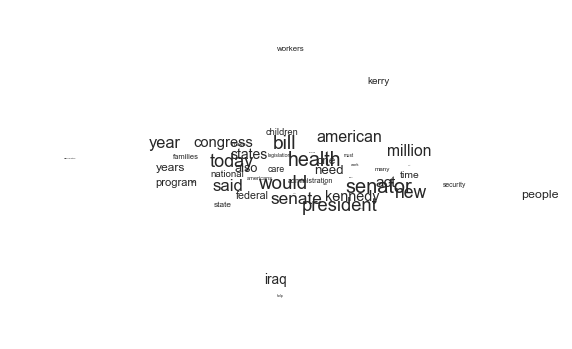

In [89]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near
``act``. ``health`` is beside ``care`` and ``national`` and ``security``. But yours will likely be different.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. 

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [90]:
resume_model  = gensim.models.word2vec.Word2Vec.load('/mnt/efs/resources/shared/resume-data')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/efs/resources/shared/resume-data'

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.index2word

Let's load a few job ads. Here, we only use a small sample of all of them. Uncomment this cell if you want to load more.

In [ ]:
# with open('data/joblistings.merged.parsed.unique.grpbyyear.2010-2015.02.tsv','r') as tsv:
#     ads = [line.strip().split('\t') for line in tsv]
    
# adsDF = pandas.DataFrame(ads, columns = ads[0])
# reducedDF = adsDF[['hiringOrganization_organizationName', 'jobDescription', 'jobLocation_address_region', 'jobLocation_geo_latitude', 'jobLocation_geo_longitude', 'qualifications', 'responsibilities']][1:]
# N = reducedDF.shape[0]
# indices = random.sample(range(1, N+1), 100)
# sampleDF = reducedDF.iloc[indices]
# sampleDF.to_csv('data/SampleJobAds.csv')

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["basic", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming.

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.



# Projection

We can also project word vectors to an arbitray semantic dimension. To
demonstrate this possibility, let's first load a model trained with New York
Times news articles.

In [79]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [80]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.34313899, -0.117117  , -0.50773001, ..., -0.99569601,
         0.92129898,  0.94376898],
       [-0.36290899, -0.26352799,  0.032661  , ..., -0.043032  ,
        -0.178965  ,  0.35355601],
       [-0.70166999, -0.34452501, -0.320714  , ...,  0.009001  ,
         0.11055   ,  0.751077  ],
       ..., 
       [-2.39162588, -1.90143001,  1.03118205, ...,  2.94746399,
         1.01587999,  2.00032997],
       [-2.43238711, -1.16141498,  1.06006396, ...,  4.40238094,
         0.500471  ,  1.64459598],
       [ 0.98193097,  0.62809402, -0.74754697, ...,  1.61292696,
         1.14806294,  1.06377602]], dtype=float32)

In [81]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [82]:
tsneWordsNYT[:,1].shape

(54,)

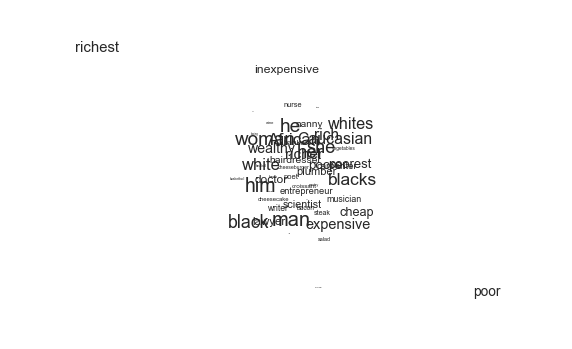

In [83]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions.

In [84]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [85]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [86]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three
dimensions.

In [87]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [88]:
OCCdf = makeDF(nytimes_model, Occupations)
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [89]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

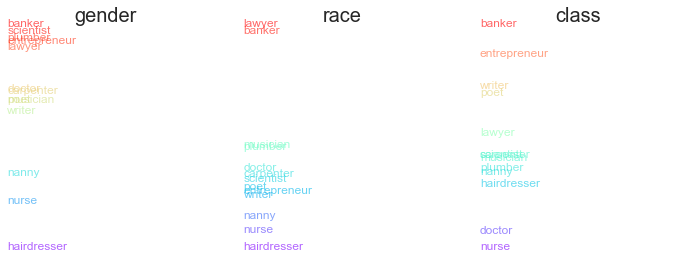

In [90]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

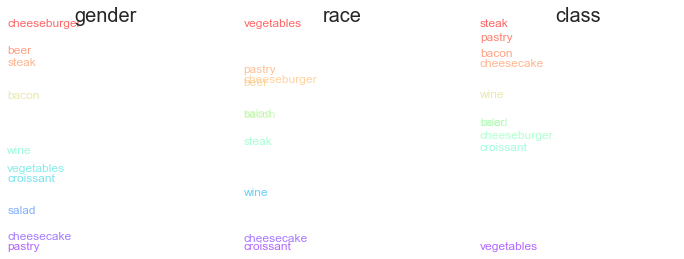

In [91]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

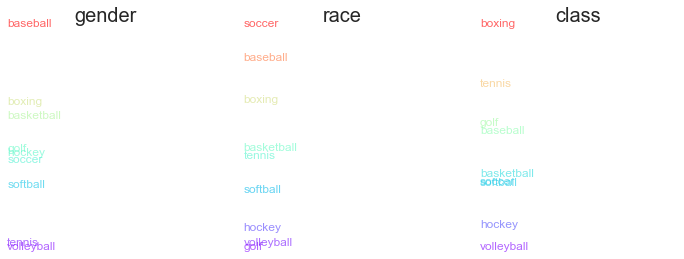

In [92]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()